In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from utils import loaders_by_classes, filter_loaders, balance
import matplotlib.pyplot as plt
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
import os
num_workers = os.cpu_count()
print(f"Nombre de CPU logiques (threads) disponibles : {num_workers}")

Nombre de CPU logiques (threads) disponibles : 12


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0,), (1,))  # Normalize images
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 100

train_loaders = loaders_by_classes(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers) 
test_loaders = loaders_by_classes(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers) 

In [4]:
balance(train_loaders)

{'0 - zero': 5923,
 '1 - one': 6742,
 '2 - two': 5958,
 '3 - three': 6131,
 '4 - four': 5842,
 '5 - five': 5421,
 '6 - six': 5918,
 '7 - seven': 6265,
 '8 - eight': 5851,
 '9 - nine': 5949}

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 channel for grayscale images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 is the result of pooling twice from 28x28
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Output: [batch_size, 32, 14, 14]
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))  # Output: [batch_size, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor for fully connected layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
# 6. Fonction pour entraîner le modèle
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Réinitialiser les gradients
        output = model(data)  # Faire une prédiction
        loss = criterion(output, target)  # Calculer la perte
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des paramètres

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# 7. Fonction pour tester le modèle
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Ajouter la perte sur l'ensemble des données de test
            pred = output.argmax(dim=1, keepdim=True)  # Trouver la classe prédite
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    return accuracy

In [6]:
test_loader = filter_loaders(test_loaders, None, batch_size, shuffle=True, num_workers=0)
data, target = next(iter(test_loader))

In [7]:
data.size()

torch.Size([100, 1, 28, 28])

In [8]:
test_loader = filter_loaders(test_loaders, None, batch_size, shuffle=True, num_workers=0)
data, target = next(iter(test_loader))
model = torch.load('./models/all_class.pth', weights_only=False)
model.eval()
data = data.to(device)

In [9]:
last_layer_name, last_layer = list(model.named_children())[-1]

In [10]:
getattr(model, last_layer_name)

Linear(in_features=128, out_features=10, bias=True)

In [11]:
w,b = getattr(model, last_layer_name).parameters()

In [12]:
b.size()

torch.Size([10])

In [13]:
for _b in b:
    print(_b.requires_grad)

True
True
True
True
True
True
True
True
True
True


In [14]:
next(getattr(model, last_layer_name).parameters()).requires_grad

True

In [15]:
w = next(last_layer.parameters())
w0 = w[0,0]
w0 = w0.detach()

In [16]:
w0.requires_grad

False

In [17]:
w0 = last_layer.weight.data[0,0]
w0.requires_grad

False

In [18]:
output = model(data)
target = target.to(device)
criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
loss.retain_grad()

In [19]:
loss.backward()

In [20]:
loss.grad

tensor(1., device='mps:0')

In [21]:
import torch

def get_jacobian(model, data, last_layer_name):
    """
    Pour un modèle `model`, un batch de données `data`, et le nom d'une couche intermédiaire `last_layer_name`,
    cette fonction retourne le Jacobien de la couche spécifiée par rapport aux paramètres du modèle.

    Args:
        model (torch.nn.Module): Le modèle PyTorch.
        data (torch.Tensor): Un batch de données (batch_size, channels, height, width).
        last_layer_name (str): Le nom de la couche intermédiaire pour laquelle calculer le Jacobien.

    Returns:
        torch.Tensor: Le Jacobien de la couche spécifiée par rapport aux paramètres du modèle.
                      Shape: [batch_size, layer_output_dim, num_parameters]
    """
    model.eval()  # Mettre le modèle en mode évaluation
    
    # Variable pour stocker la sortie de la couche intermédiaire
    layer_output = None

    # Hook pour capturer la sortie de la couche spécifiée
    def hook(module, input, output):
        nonlocal layer_output
        layer_output = output

    # Enregistrer le hook sur la couche spécifiée
    layer = dict(model.named_modules())[last_layer_name]
    hook_handle = layer.register_forward_hook(hook)

    # Exécuter une passe avant pour obtenir la sortie de la couche
    model(data)
    
    # Supprimer le hook après avoir capturé la sortie
    hook_handle.remove()

    # S'assurer que la sortie de la couche cible a été capturée
    if layer_output is None:
        raise ValueError(f"La couche '{last_layer_name}' n'a pas produit de sortie. Vérifiez le nom de la couche.")

    # On a besoin de "layer_output" en tant que cible du Jacobien, et des paramètres du modèle
    params = list(model.parameters())
    num_parameters = sum(p.numel() for p in params)  # Nombre total de paramètres

    # Redimensionner la sortie de la couche pour un traitement plus simple
    batch_size = layer_output.size(0)
    layer_output_flat = layer_output.view(batch_size, -1)  # Flatten layer output per sample
    layer_output_dim = layer_output_flat.size(1)

    # Calculer le Jacobien pour chaque échantillon du batch
    jacobians = []
    for i in range(batch_size):
        # Fonction pour calculer la sortie aplatie de la couche intermédiaire pour un échantillon
        def single_output(*model_params):
            idx = 0
            for param, model_param in zip(params, model_params):
                param.data = model_param.data  # Mettre à jour les paramètres du modèle
                idx += 1
            return layer_output_flat[i]

        # Calcul du Jacobien de la couche spécifiée pour l'échantillon `i`
        jacobian_i = torch.autograd.functional.jacobian(single_output, tuple(params), create_graph=True)
        
        # Transformer le Jacobien en un vecteur de forme [layer_output_dim, num_parameters]
        jacobian_i = torch.cat([j.view(-1) for j in jacobian_i], dim=0).view(layer_output_dim, num_parameters)
        jacobians.append(jacobian_i)

    # Empiler les Jacobians pour chaque échantillon du batch
    jacobian_matrix = torch.stack(jacobians)  # Shape: [batch_size, layer_output_dim, num_parameters]

    return jacobian_matrix

In [22]:
data = data.to(device)
model(data)
torch.max(get_jacobian(model, data, last_layer_name))

tensor(0., device='mps:0')

In [23]:
# Forward pass to get `y` at some layer
y = model(data)

# Create a list to store the Jacobians
jacobians = []

# Loop over each element in the batch
for i in range(batch_size):
    # Initialize Jacobian matrix for this element in the batch
    jacobian = []
    
    # Loop over each output element in `y` for this data point
    for j in range(y.shape[1]):
        # Zero gradients
        model.zero_grad()
        
        # Backward pass for each output element in `y`
        y[i, j].backward(retain_graph=True)
        
        # Collect the gradients with respect to each parameter
        grads = torch.cat([param.grad.view(-1) for param in model.parameters()])
        
        # Append the gradient (row of the Jacobian) to the jacobian list
        jacobian.append(grads)
    
    # Stack the gradients to form a matrix and add it to the jacobians list
    jacobians.append(torch.stack(jacobian))

# Stack the jacobians for each data point in the batch
jacobian_matrix = torch.stack(jacobians)  # Shape: [batch_size, y_dim, num_params]

print("Jacobian shape:", jacobian_matrix.shape)

Jacobian shape: torch.Size([100, 10, 421642])


In [24]:

# Get the last layer
last_layer_name, last_layer = list(model.named_children())[-1]

# Define a function that computes the output of the last layer
def model_last_layer_output(data):
    output = model(data)
    return getattr(model, last_layer_name)(output)

# Compute the Jacobian with respect to the input `data`
jacobian_matrix = torch.autograd.functional.jacobian(model_last_layer_output, data)

print("Jacobian shape:", jacobian_matrix.shape)

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (100x10 and 128x10)

In [ ]:
data = data.to(device)

# Forward pass to get `y` at some layer
y = model(data)

# Create a list to store the Jacobians
jacobians = []

# Loop over each element in the batch
for i in range(batch_size):
    # Initialize Jacobian matrix for this element in the batch
    jacobian = []
    
    # Loop over each output element in `y` for this data point
    for j in range(y.shape[1]):
        # Zero gradients
        model.zero_grad()
        
        # Backward pass for each output element in `y`
        y[i, j].backward(retain_graph=True)
        
        # Collect the gradients with respect to each parameter
        grads = torch.cat([param.grad.view(-1) for param in model.parameters()])
        
        # Append the gradient (row of the Jacobian) to the jacobian list
        jacobian.append(grads)
    
    # Stack the gradients to form a matrix and add it to the jacobians list
    jacobians.append(torch.stack(jacobian))

# Stack the jacobians for each data point in the batch
jacobian_matrix = torch.stack(jacobians)  # Shape: [batch_size, y_dim, num_params]

print("Jacobian shape:", jacobian_matrix.shape)

Jacobian shape: torch.Size([100, 10, 421642])


In [ ]:
torch.max(jacobian_matrix[0], dim=1)

torch.return_types.max(
values=tensor([9.5819e+00, 9.5819e+00, 9.5819e+00, 9.5818e+00, 9.5770e+00, 9.5818e+00,
        9.5819e+00, 9.5811e+00, 9.5789e+00, 8.6428e-03], device='mps:0'),
indices=tensor([420448, 420576, 420704, 420832, 420960, 421088, 421216, 421344, 421472,
        421600], device='mps:0'))

In [ ]:
target

tensor([3, 4, 7, 0, 1, 4, 3, 1, 9, 1, 4, 2, 7, 4, 6, 4, 4, 0, 1, 7, 2, 2, 2, 6,
        3, 9, 4, 9, 3, 3, 3, 3, 0, 4, 8, 4, 4, 0, 9, 3, 5, 2, 5, 4, 1, 2, 6, 5,
        2, 9, 3, 4, 7, 1, 8, 3, 1, 9, 6, 1, 5, 7, 0, 2, 1, 3, 4, 2, 3, 8, 7, 1,
        2, 7, 9, 4, 9, 6, 1, 1, 0, 9, 1, 4, 1, 2, 9, 1, 4, 4, 7, 1, 7, 2, 8, 5,
        1, 4, 0, 1])

In [ ]:
target = target.to(device)
criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
loss.retain_grad()

In [ ]:
loss


tensor(0.0555, device='mps:0', grad_fn=<NllLossBackward0>)

In [ ]:
loss.backward(retain_graph=True)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
output.grad.size()

torch.Size([100, 10])

In [ ]:
base

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
loss.grad

tensor(1., device='mps:0')

In [ ]:
test_loader = filter_loaders(test_loaders, None, batch_size, shuffle=True, num_workers=0)
optimizer = optim.Adam(base.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(base, device, test_loader)

TypeError: train() missing 2 required positional arguments: 'optimizer' and 'epoch'

In [ ]:
# # Ground Truth
    
# train_loader = filter_loaders(train_loaders, None, batch_size, shuffle=True, num_workers=0)
# test_loader = filter_loaders(test_loaders, None, batch_size, shuffle=True, num_workers=0)

# model = ConvNet()
# device = torch.device("mps")
# model.to(device)



# num_epochs = 5
# for epoch in range(1, num_epochs + 1):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

# torch.save(model, './models/all_class.pth') 

# for class_name in list(train_loaders.keys()):
#     print(class_name)
    
#     train_loader = filter_loaders(train_loaders, class_name, batch_size, shuffle=True, num_workers=0)
#     test_loader = filter_loaders(test_loaders, class_name, batch_size, shuffle=True, num_workers=0)

#     model = ConvNet()
#     device = torch.device("mps")
#     model.to(device)

#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     criterion = nn.CrossEntropyLoss()

#     num_epochs = 5
#     for epoch in range(1, num_epochs + 1):
#         train(model, device, train_loader, optimizer, epoch)
#         test(model, device, test_loader)

#     torch.save(model, f'./models/no_{class_name}.pth') 

In [ ]:
ones = torch.ones(1, 3)
empt = torch.empty(1, 3)
torch.cat([ones, empt], dim=0)

tensor([[1., 1., 1.],
        [0., 0., 0.]])

In [ ]:
list(test_loaders.keys()).index('0 - zero')

0

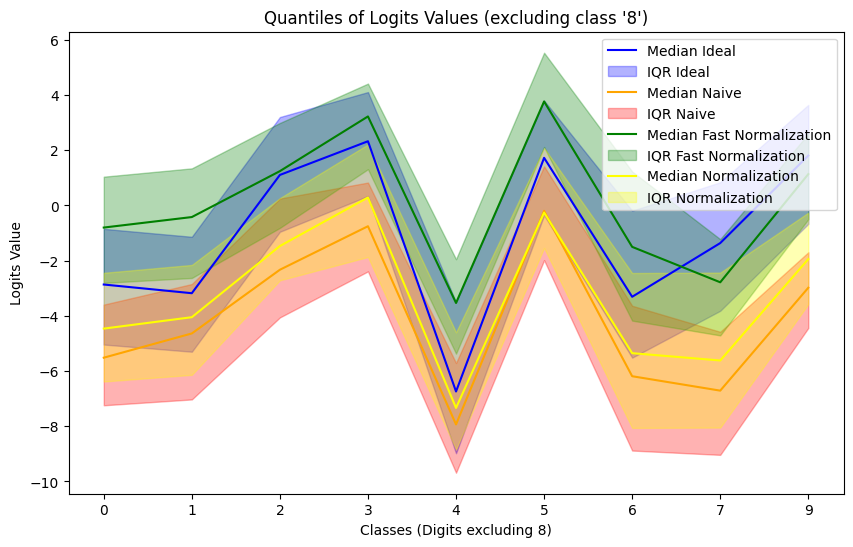

In [ ]:


device = torch.device("mps")  # Utilisation de 'mps' (Apple Silicon), sinon 'cuda' ou 'cpu'

class_name = '8 - eight'  # Tu peux changer cela pour d'autres classes comme '1 - one', '2 - two', etc.
# Extraire le numéro de la classe à partir de 'class_name'
class_num = int(class_name.split(' ')[0])

# Charger les modèles
ideal = torch.load(f'./models/no_{class_name}.pth', weights_only=False)
base = torch.load('./models/all_class.pth', weights_only=False)

ideal.eval()
base.eval()

ideal.to(device)
base.to(device)

def sample_logits(class_name, model, loaders, device):
    loader = loaders[class_name]
    model.eval()

    # Sélectionner un batch aléatoire
    loader_list = list(loader)  # Convertir le DataLoader en liste pour pouvoir indexer
    random_batch = random.choice(loader_list)  # Choisir un batch aléatoire

    data, _ = random_batch  # Extraire les données (ignorer les labels)
    data = data.to(device)  # Envoyer les données sur le device

    # Passer les données à travers le modèle pour obtenir les logits
    with torch.no_grad():
        output = model(data)  # Calculer les logits pour ce batch

    return output  # Retourne les logits pour le batch sélectionné

def sample_all_logits(model, loaders, device):
    "return dict keys : sample of logits"
    all_logits = []
    for class_name in loaders.keys():
        logits = sample_logits(class_name, model, loaders, device)
        all_logits.append(logits)
    return dict(zip(loaders.keys(), all_logits))

def sample_pre_softmax(class_name, model, loaders, device):
    logits = None  # Variable locale pour stocker les logits

    # Définir la fonction hook pour capturer les logits avant le softmax
    def hook_fn(module, input, output):
        nonlocal logits  # Utiliser nonlocal pour accéder à logits dans l'enclosant
        logits = output  # Capture les logits ici
    
    # Enregistrer un hook sur la dernière couche du modèle
    last_layer_name, last_layer = list(model.named_children())[-1]
    hook = last_layer.register_forward_hook(hook_fn)

    # Sélectionner un batch aléatoire dans le DataLoader
    loader = loaders[class_name]
    random_batch = next(iter(loader))  # Prendre un batch du loader (au lieu de convertir en liste)

    data, _ = random_batch  # Extraire les données (ignorer les labels)
    data = data.to(device)  # Envoyer les données sur le device

    # Passer les données à travers le modèle pour obtenir les logits
    with torch.no_grad():
        _ = model(data)  # Les logits seront capturés dans hook_fn

    # Retirer le hook une fois terminé
    hook.remove()

    return logits  # Retourner les logits capturés avant le softmax

def sample_all_pre_softmax(model, loaders, device):
    "return dict keys : sample of logits"
    all_logits = []
    for class_name in loaders.keys():
        logits = sample_pre_softmax(class_name, model, loaders, device)
        all_logits.append(logits)
    return dict(zip(loaders.keys(), all_logits))

def naive_method(output, class_num):
    # Exclusion de la classe cible des logits
    naive_output = torch.cat([output[:, :class_num], output[:, class_num+1:]], dim=1)
    return naive_output

def fast_normalization_method(output, class_num):
    # Exclusion de la classe cible des logits
    output_excluded = torch.cat([output[:, :class_num], output[:, class_num+1:]], dim=1)
    # Moyenne sur toutes les classes restantes
    mean_excluded = torch.mean(output_excluded, dim=1, keepdim=True)
    # Soustraction de la moyenne
    normalized_output = output_excluded - mean_excluded
    return normalized_output

def normalization_method(class_name, model, loaders, device):
    outputs = sample_all_pre_softmax(model, loaders, device)
    keys = list(outputs.keys())
    class_num = list(outputs.keys()).index(class_name)

    output_excluded = torch.cat([outputs[class_name][:, :class_num], outputs[class_name][:, class_num+1:]], dim=1).to(device)
    mean_excluded = torch.mean(output_excluded, dim=1, keepdim=True).to(device)
    keys.pop(class_num)

    mean_others = torch.zeros_like(mean_excluded).to(device)
    for class_name in keys:
        class_output_excluded = torch.cat([outputs[class_name][:, :class_num], outputs[class_name][:, class_num+1:]], dim=1).to(device)
        mean_others += torch.mean(class_output_excluded, dim=1, keepdim=True)
    mean_others = mean_others / len(keys)

    normalized_output = output_excluded - mean_excluded + mean_others
    return normalized_output.cpu()

# Fonction pour obtenir les valeurs softmax pour un batch d'images avec une méthode donnée
def get_softmax_values(model, loaders, device, class_num, method):
    output = sample_logits(class_name, model, loaders, device)
    truncated_ouput = method(output, class_num).cpu()
    softmax_output = F.log_softmax(truncated_ouput, dim=1) # Appliquer la méthode (naïve ou normalisation)
    return softmax_output

def get_pre_softmax_values(model, loaders, device, class_num, method):
    output = sample_pre_softmax(class_name, model, loaders, device)
    truncated_ouput = method(output, class_num).cpu()
    return truncated_ouput

loaders = test_loaders
# Obtenir les softmax pour les deux modèles en utilisant les méthodes
model_naive_softmax = get_pre_softmax_values(base, loaders, device, class_num, naive_method)
model_fast_normalization_softmax = get_pre_softmax_values(base, loaders, device, class_num, fast_normalization_method)
model_normalization_softmax = normalization_method(class_name, base, loaders, device)

ideal_softmax = naive_method(sample_pre_softmax(class_name, ideal, loaders, device), class_num).cpu()

# Calculer les quantiles de softmax (valeurs de distribution) pour chaque modèle
quantiles_naive = np.quantile(model_naive_softmax.numpy(), [0, 0.25, 0.5, 0.75, 1], axis=0)
quantiles_fast_normalization = np.quantile(model_fast_normalization_softmax.numpy(), [0, 0.25, 0.5, 0.75, 1], axis=0)
quantiles_normalization = np.quantile(model_normalization_softmax.numpy(), [0, 0.25, 0.5, 0.75, 1], axis=0)
quantiles_base = np.quantile(ideal_softmax.numpy(), [0, 0.25, 0.5, 0.75, 1], axis=0)

# Tracer les quantiles de softmax pour chaque méthode
x = np.arange(1, model_naive_softmax.size(1) + 1)  # Ajuster les classes pour 1 à 9 (en excluant la classe supprimée)
plt.figure(figsize=(10, 6))

# Méthode Idéale (base)
plt.plot(x, quantiles_base[2], label='Median Ideal', color='blue', linestyle='-')
plt.fill_between(x, quantiles_base[1], quantiles_base[3], color='blue', alpha=0.3, label='IQR Ideal')

# Méthode Naïve
plt.plot(x, quantiles_naive[2], label='Median Naive', color='orange', linestyle='-')
plt.fill_between(x, quantiles_naive[1], quantiles_naive[3], color='red', alpha=0.3, label='IQR Naive')

# Méthode Fast Normalization
plt.plot(x, quantiles_fast_normalization[2], label='Median Fast Normalization', color='green', linestyle='-')
plt.fill_between(x, quantiles_fast_normalization[1], quantiles_fast_normalization[3], color='green', alpha=0.3, label='IQR Fast Normalization')

# Méthode Normalization
plt.plot(x, quantiles_normalization[2], label='Median Normalization', color='yellow', linestyle='-')
plt.fill_between(x, quantiles_normalization[1], quantiles_normalization[3], color='yellow', alpha=0.3, label='IQR Normalization')

# Ajuster les labels pour les classes
remaining_classes = [i for i in range(10) if i != class_num]  # Les classes sans la classe exclue
plt.xticks(ticks=np.arange(1, model_naive_softmax.size(1) + 1), labels=[str(i) for i in remaining_classes])

plt.xlabel(f"Classes (Digits excluding {class_num})")
plt.ylabel("Logits Value")
plt.title(f"Quantiles of Logits Values (excluding class '{class_num}')")
plt.legend()
plt.show()

{'0 - zero': tensor([[-4.7684e-07, -2.0315e+01, -1.4909e+01,  ..., -2.0756e+01,
          -1.9857e+01, -1.8487e+01],
         [-5.9605e-07, -2.0003e+01, -1.4609e+01,  ..., -1.7164e+01,
          -1.7217e+01, -1.6676e+01],
         [-7.2357e-05, -1.8302e+01, -1.6427e+01,  ..., -1.8263e+01,
          -1.4822e+01, -1.6993e+01],
         ...,
         [-5.9864e+00, -6.1875e+00, -7.0674e+00,  ..., -1.2146e+01,
          -9.3953e-03, -1.0616e+01],
         [-1.1921e-07, -2.2680e+01, -1.6599e+01,  ..., -2.0217e+01,
          -1.9895e+01, -1.7177e+01],
         [ 0.0000e+00, -2.4354e+01, -1.7139e+01,  ..., -2.0328e+01,
          -1.7145e+01, -2.3395e+01]], device='mps:0'),
 '1 - one': tensor([[-2.2862e+01, -1.5497e-06, -2.0139e+01,  ..., -1.6427e+01,
          -1.5934e+01, -1.9238e+01],
         [-2.3358e+01, -9.7751e-06, -1.8534e+01,  ..., -1.1819e+01,
          -1.7935e+01, -1.8831e+01],
         [-2.1180e+01, -1.6332e-05, -1.7782e+01,  ..., -1.1726e+01,
          -1.5567e+01, -1.3588e+01],


In [ ]:
import torch

class_name = '0 - zero'
output = get_logits(class_name, ideal, loaders = train_loaders, device = device)
torch.exp(output.mean(dim=0))

tensor([9.9428e-01, 9.1451e-11, 5.7241e-08, 1.5029e-09, 1.3490e-10, 1.6004e-07,
        1.3524e-06, 7.6858e-12, 9.1404e-07, 1.3805e-07], device='mps:0')

In [ ]:
naive_method(output, class_num).size()

torch.Size([128, 9])

In [ ]:

num_workers

12

Nombre de CPU logiques (threads) disponibles : 12
